In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import seaborn as sns
import math
import re
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
import statsmodels.api as sm
from statsmodels.formula.api import ols
pd.set_option('display.max_columns', 100)

In [2]:
df = pd.read_csv('final_df.csv')

# Feature Engineering

In [3]:
# Drop Nulls in Temperature
df = df.dropna(subset=['weather_temperature'])

# Drop Uneeded Rows
df = df.drop(columns=['weather_humidity','weather_detail','stadium_address','stadium_weather_station_code',
                      'stadium_weather_type','STATION','ELEVATION','team_away','team_home','team_favorite_id',
                      'LATITUDE','LONGITUDE','zipcode','zipcode_away','stadium_name','home_OSRS','home_MoV',
                      'home_PD','away_OSRS','away_MoV','away_PD','schedule_season',
                      'away_DSRS','away_SRS','home_DSRS','home_SRS','diff_MoV','diff_SRS','diff_OSRS'])
 
df.drop(columns=['score_home','score_away', 'stadium_location','total'],inplace=True)
df.drop('schedule_date', axis=1,inplace=True)

# Transform Over/Under Results to Binary 0 = Under, 1 = Over
df['over_under_result'] = np.where(df['over_under_result'] == 'Over',1,0)
# Transform Stadium Surface to Binary 0 = Turf, 1 = Grass 
df['stadium_surface'] = np.where(df['stadium_surface'] == 'Grass',1,0)

# True/False to Binary 0 = False, 1 = True
df['schedule_playoff'] = list(map(int, df['schedule_playoff']))
df['stadium_neutral'] = list(map(int, df['stadium_neutral']))

# Get Dummies for Categorical Variables
df = pd.get_dummies(df, columns = ['stadium_type'], drop_first= True)
#df = pd.get_dummies(df, columns = ['stadium_name'], drop_first= True)
#df = pd.get_dummies(df, columns = ['team_home'], drop_first= True)
#df = pd.get_dummies(df, columns = ['team_away'], drop_first= True)
#df = pd.get_dummies(df, columns = ['team_favorite_id'], drop_first= True)

# Transform Uint8 values to Integers
uint8_columns = list(df.select_dtypes('uint8').columns)
for colname in df.columns:
    if colname in uint8_columns:
        df[colname] = df[colname].astype(int)

In [4]:
#df.columns[df.isnull().any()]
print(df.shape)
df.columns

(9406, 31)


Index(['schedule_week', 'schedule_playoff', 'spread_favorite',
       'over_under_line', 'stadium_neutral', 'weather_temperature',
       'weather_wind_mph', 'over_under_result', 'stadium_open',
       'stadium_capacity', 'stadium_surface', 'dist_diff', 'weekday',
       'home_W-L%', 'home_SoS', 'home_PF_per_game', 'home_PA_per_game',
       'away_W-L%', 'away_SoS', 'away_PF_per_game', 'away_PA_per_game',
       'home_superbowl_odds', 'away_superbowl_odds', 'diff_W-L%', 'diff_PD',
       'diff_SoS', 'diff_PF_per_game', 'diff_PA_per_game',
       'diff_superbowl_odds', 'stadium_type_outdoor',
       'stadium_type_retractable'],
      dtype='object')

# Feature Selection

In [5]:
# Split data to be used in the models
# Create matrix of features
X = df.drop('over_under_result', axis=1) # grabs everything else but 'Default'

# Create target variable
y = df['over_under_result'] # y is the column we're trying to predict

In [6]:
np.abs(df.corr()['over_under_result']).sort_values(ascending=False)

over_under_result           1.000000
weather_wind_mph            0.041687
dist_diff                   0.023850
away_SoS                    0.023747
over_under_line             0.022807
schedule_playoff            0.021816
home_PF_per_game            0.021115
home_superbowl_odds         0.018859
away_W-L%                   0.017535
home_W-L%                   0.016615
home_SoS                    0.015655
diff_PF_per_game            0.013421
diff_superbowl_odds         0.012336
stadium_type_outdoor        0.010378
home_PA_per_game            0.009671
schedule_week               0.009645
stadium_surface             0.009496
diff_PA_per_game            0.009128
away_superbowl_odds         0.008661
away_PA_per_game            0.007909
diff_PD                     0.007473
weather_temperature         0.006078
stadium_capacity            0.005567
stadium_neutral             0.004881
away_PF_per_game            0.003609
spread_favorite             0.003602
diff_SoS                    0.003506
w

In [7]:
corrs_dict={}
for col in X.columns:
    corr=y.corr(X[col])
    corrs_dict[corr]=col
    
sorted(corrs_dict.items(),reverse=True)

[(0.02384988059649397, 'dist_diff'),
 (0.023746613284840436, 'away_SoS'),
 (0.021815981644116224, 'schedule_playoff'),
 (0.021115196696975463, 'home_PF_per_game'),
 (0.01753540348966557, 'away_W-L%'),
 (0.016614989105279022, 'home_W-L%'),
 (0.01342067711104437, 'diff_PF_per_game'),
 (0.009644803153826043, 'schedule_week'),
 (0.009127760465554378, 'diff_PA_per_game'),
 (0.007472746640144845, 'diff_PD'),
 (0.003609124412592774, 'away_PF_per_game'),
 (0.003601975708576484, 'spread_favorite'),
 (0.0035061670778537522, 'diff_SoS'),
 (0.0020866904445705856, 'weekday'),
 (0.0018922105888797213, 'stadium_type_retractable'),
 (0.0009258487993542348, 'stadium_open'),
 (0.0009067093043720111, 'diff_W-L%'),
 (-0.004881212505240982, 'stadium_neutral'),
 (-0.005566825484400524, 'stadium_capacity'),
 (-0.006078053752036983, 'weather_temperature'),
 (-0.007909001698108256, 'away_PA_per_game'),
 (-0.008661073387836874, 'away_superbowl_odds'),
 (-0.009496358803837047, 'stadium_surface'),
 (-0.0096708102

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_(X):
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif['Features'] = X.columns
    return vif
Vif = vif_(X)

Vif.sort_values('VIF',ascending=False)[:5]

,VIF,Features
7,425.991156,stadium_open
3,136.676337,over_under_line
15,110.782790,home_PA_per_game
19,106.945152,away_PA_per_game
14,93.566145,home_PF_per_game


# Baseline Model

In [9]:
from sklearn.model_selection import KFold
from sklearn.svm import SVR

In [10]:
#Split the Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

In [11]:
# Scale the Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data = X_train, columns = X.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data = X_test,columns = X.columns)

In [12]:
from sklearn.linear_model import LogisticRegressionCV

logreg = LogisticRegressionCV()

logreg.fit(X_train, y_train)

base_logred_train_pred = logreg.predict(X_train)
base_logred_test_pred = logreg.predict(X_test)


base_logreg_recall = metrics.recall_score(y_test, base_logred_test_pred)
base_logred_train_f1_score = f1_score(y_train, base_logred_train_pred)
base_logreg_test_f1_score = f1_score(y_test, base_logred_test_pred)


print('Train F1 score: ', base_logred_train_f1_score)
print('Test F1 score: ', base_logreg_test_f1_score)

Train F1 score:  0.4328958880139983
Test F1 score:  0.4116727462219906


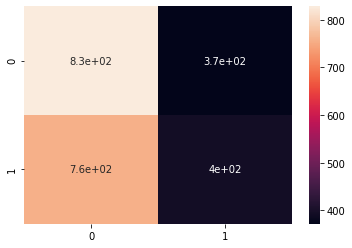

In [13]:
cm = confusion_matrix(y_test,base_logred_test_pred)
sns.heatmap(cm,annot=True);

## Decision Tree

In [14]:
# Simple decision tree (ID3)
from sklearn.tree import DecisionTreeClassifier 

clf = DecisionTreeClassifier(random_state=1, criterion = 'gini', max_depth = 7, min_samples_leaf = 7, min_samples_split = 2)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

clf_f1_train = round(f1_score(y_train, y_pred_train), 3)
clf_f1_test = round(f1_score(y_test, y_pred), 3)
clf_recall = round(metrics.recall_score(y_test, y_pred), 3)

print('Train F1 score: ', clf_f1_train)
print('Test F1 score: ', clf_f1_test)

Train F1 score:  0.522
Test F1 score:  0.446


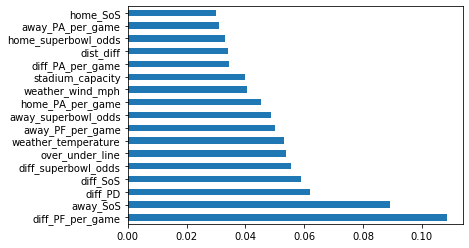

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(17).plot(kind='barh')
plt.show()

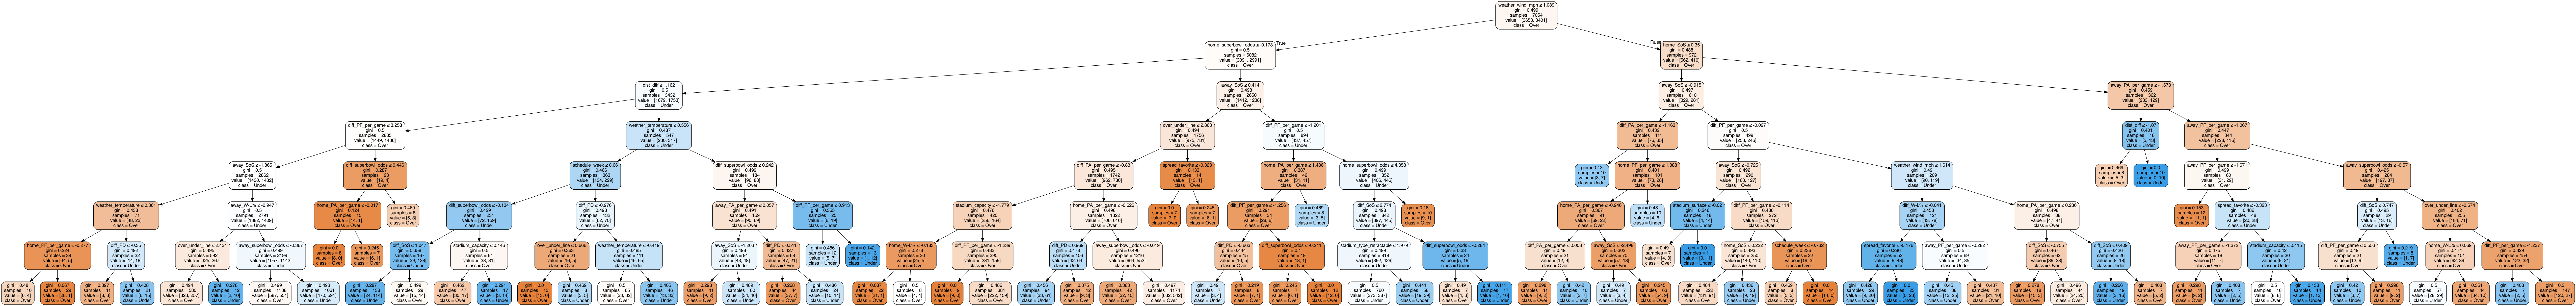

In [16]:
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns,class_names=['Over','Under'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

## Decision Tree w/ Gridsearch

In [17]:
from sklearn.model_selection import GridSearchCV
d_tree = DecisionTreeClassifier()
parameters = {"max_depth":range(15,25,1),
              "criterion":["entropy"], 
              "min_samples_leaf":range(50,80,5),
              "splitter":["best"],
              "max_features":range(1,28)}
d_tree_grid = GridSearchCV(d_tree,param_grid=parameters,scoring='f1',n_jobs=-1,cv=5,verbose=1)

In [18]:
d_tree_grid.fit(X_train,y_train)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1260 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 3260 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 6060 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 | elapsed:  1.5min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(15, 25),
                         'max_features': range(1, 28),
                         'min_samples_leaf': range(50, 80, 5),
                         'splitter': ['best']},
             scoring='f1', verbose=1)

In [19]:
print(d_tree_grid.best_score_)
print(d_tree_grid.best_params_)
print(d_tree_grid.best_estimator_)

0.4978000898924305
{'criterion': 'entropy', 'max_depth': 15, 'max_features': 22, 'min_samples_leaf': 50, 'splitter': 'best'}
DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features=22,
                       min_samples_leaf=50)


In [20]:
y_pred_d_tree_train = d_tree_grid.best_estimator_.predict(X_train)
y_pred_d_tree = d_tree_grid.best_estimator_.predict(X_test)

In [21]:
gcv_decision_tree_recall_train = metrics.recall_score(y_train, y_pred_d_tree_train)
gcv_decision_tree_recall_score = metrics.recall_score(y_test, y_pred_d_tree)
gcv_decision_tree_f1_score = f1_score(y_test, y_pred_d_tree)
gcv_decision_tree_f1_train_score = f1_score(y_train, y_pred_d_tree_train)


print('Train F1 score: ', gcv_decision_tree_f1_train_score)
print('Test F1 score: ', gcv_decision_tree_f1_score)

Train F1 score:  0.5963704630788486
Test F1 score:  0.4415823367065317


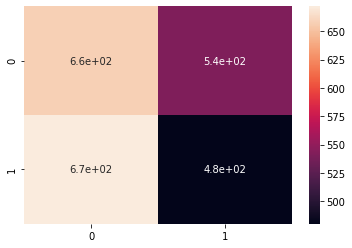

In [22]:
cm2 = confusion_matrix(y_test,y_pred_d_tree)
sns.heatmap(cm2,annot=True);

# Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)
rfc.fit(X_train, y_train)
rfc_predicted = rfc.predict(X_test)
rfc_predicted_train = rfc.predict(X_train)
rfc_recall_score = metrics.recall_score(y_test, rfc_predicted)

In [24]:
rfc_f1_train = round(f1_score(y_train, rfc_predicted_train), 3)
rfc_f1_test = round(f1_score(y_test, rfc_predicted), 3)
rfc_recall = round(metrics.recall_score(y_test, rfc_predicted), 3)

print('Recall Score: ', rfc_recall)
print('Train F1 score: ', rfc_f1_train)
print('Test F1 score: ', rfc_f1_test)

Recall Score:  0.269
Train F1 score:  0.475
Test F1 score:  0.358
